In [19]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import numpy as np
from pyuvdata import UVCal, UVData, utils
import os
import sys
import glob
import uvtools as uvt
from astropy.time import Time
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, Angle
import pandas
import warnings 
import copy
import utils
from hera_mc import cm_hookup
warnings.filterwarnings('ignore')

In [14]:
# get data location
#data_path = os.environ['DATA_PATH']
data_path = '/lustre/aoc/projects/hera/dstorer/Projects/H3C/data/2458778'
#data_path = '/lustre/aoc/projects/hera/rnunhoke/H3C/2458763'
#data_path = '/lustre/aoc/projects/hera/lberkhou/Test/2458701'

In [15]:
# Load in data
HHfiles, uvdx, uvdy, uvd1, uvd2, uvd_diff, uvd_sum = utils.load_data(data_path)

## Autocorrelations for a single file

This plot shows autocorrelations for one timestamp of each antenna that is active and each polarization

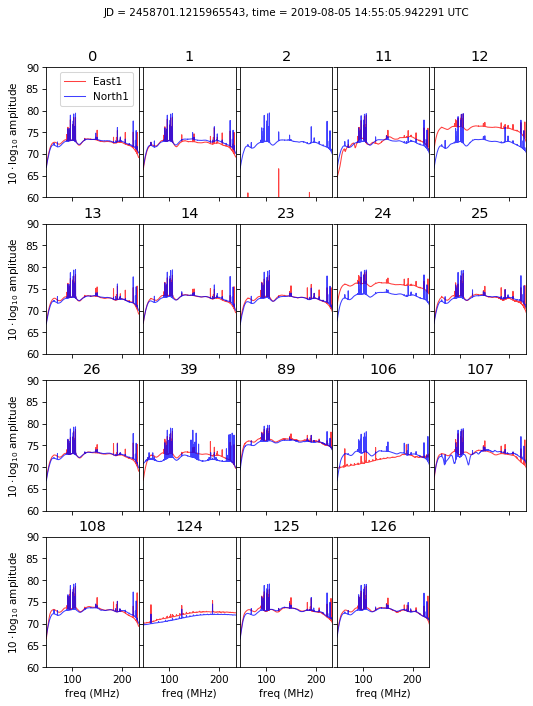

In [4]:
### plot autos
utils.plot_autos(uvdx, uvdy, uvd1, uvd2)

## Waterfalls of Autocorrelation Amplitudes for each Antenna and Each polarization

In [5]:
uvd = UVData()
uvd.read_uvh5(HHfiles, ant_str = 'autos')
lst0 = np.min(uvd1.lst_array) 
lst1 = np.max(uvd2.lst_array)

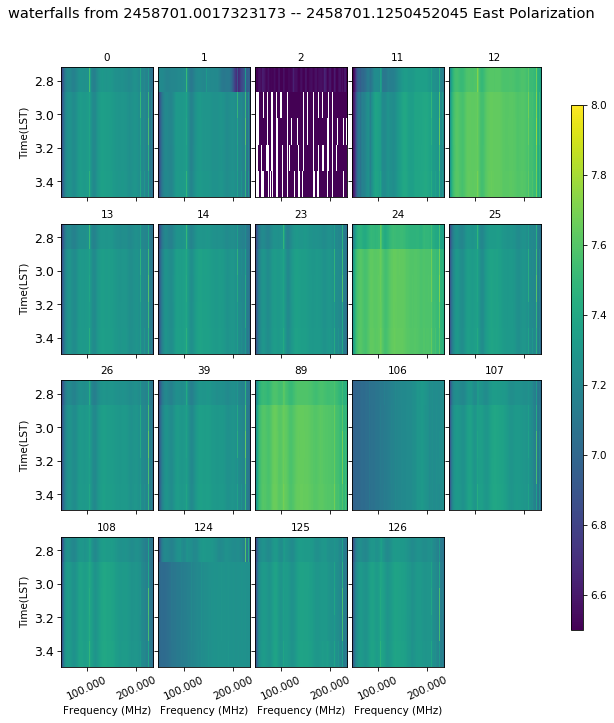

In [7]:
utils.plot_wfs(uvd, pol = 0)

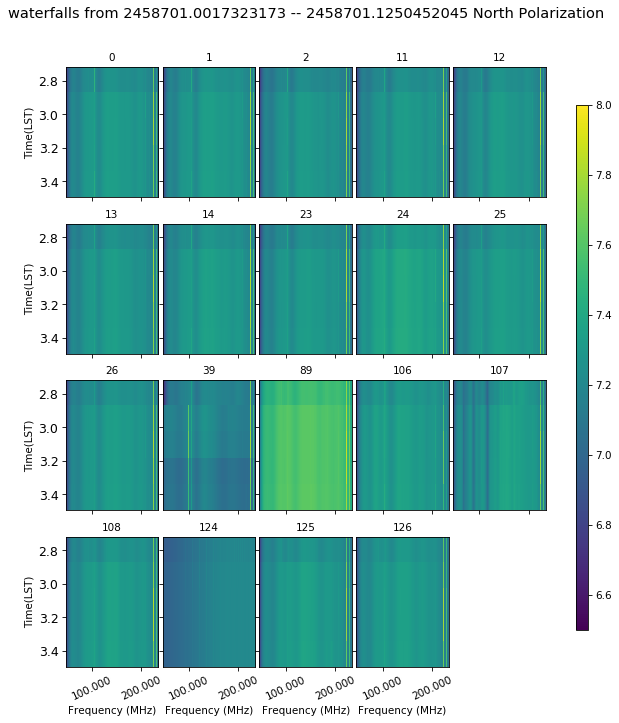

In [8]:
utils.plot_wfs(uvd, pol = 1)

## Correlation Matrices

NameError: name 'EarthLocation' is not defined

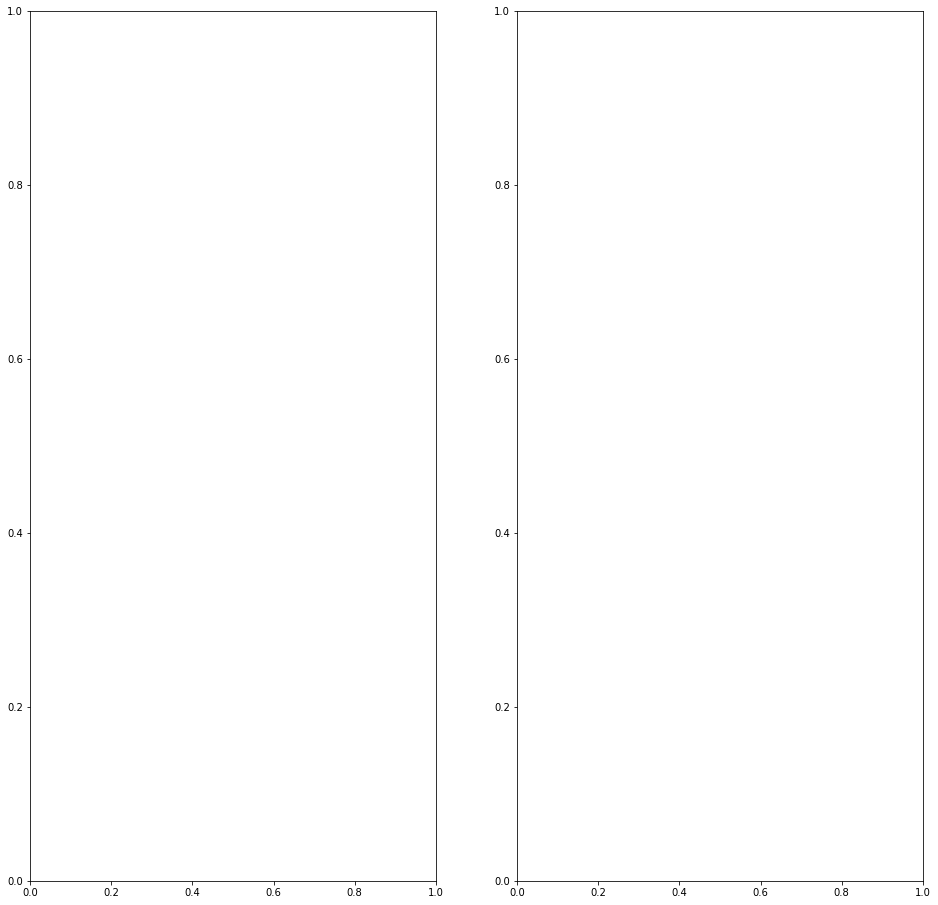

In [20]:
node_dict={
    0: [11,12,13,14,23,24,25,26,39],
    7: [81,82,83,98,99,100,116,117,118,119,137,138],
    8: [84,85,86,87,101,102,103,104,120,121,122,123],
    9: [88,89,90,91,105,106,107,108,124,125,126]
}

matrix = utils.calcEvenOddAmpMatrix(uvd_sum,uvd_diff,nodes=node_dict)
utils.plotCorrMatrix(uvd_sum, matrix, nodes=node_dict)

In [16]:
uv = uvd_sum
antnums = uv.antenna_numbers
h = cm_hookup.Hookup()
x = h.get_hookup('HH')
nodes = {}

In [ ]:
    antnums = uv.antenna_numbers
    h = cm_hookup.Hookup()
    x = h.get_hookup('HH')
    nodes = {}
    for ant in antnums:
        key = 'HH%i:A' % (ant)
        n = x[key].get_part_in_hookup_from_type('node')['E<ground'][2]
        if n in nodes:
            nodes[n].append(ant)
        else:
            nodes[n] = [ant]